## Import Modules

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib

## Load and Preprocess Data

In [21]:
# Load and preprocess
df = pd.read_csv("fleet_train.csv")
df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df = df.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# --- Load and preprocess test data ---
df_test = pd.read_csv("fleet_monitor_notscored_2.csv")  # <-- Update as needed
df_test["Measurement_timestamp"] = pd.to_datetime(df_test["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
df_test = df_test.sort_values(by=["Region", "truckid", "Measurement_timestamp"]).reset_index(drop=True)

# Sensor features
features = [
    "Vehicle_speed_sensor", "Vibration", "Engine_Load", "Engine_Coolant_Temp", "Intake_Manifold_Pressure",
    "Engine_RPM", "Speed_OBD", "Intake_Air_Temp", "Mass_Air_Flow_Rate", "Throttle_Pos_Manifold",
    "Voltage_Control_Module", "Ambient_air_temp", "Accel_Pedal_Pos_D", "Engine_Oil_Temp", "Speed_GPS",
    "Turbo_Boost_And_Vcm_Gauge", "Trip_Distance", "Litres_Per_100km_Inst", "Accel_Ssor_Total",
    "CO2_in_g_per_km_Inst", "Trip_Time_journey"
]

# Normalize
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df_test[features] = scaler.fit_transform(df_test[features])
joblib.dump(scaler, "scaler.save")

['scaler.save']

## Apply SMOTE

In [22]:
# Sequence extraction
SEQUENCE_LENGTH = 30
X_seq, y_seq = [], []

for _, group in df.groupby(["Region", "truckid"]):
    if len(group) < SEQUENCE_LENGTH:
        continue
    X = group[features].values
    y = group["Maintenance_flag"].values
    for i in range(len(X) - SEQUENCE_LENGTH):
        X_seq.append(X[i:i+SEQUENCE_LENGTH])
        y_seq.append(y[i+SEQUENCE_LENGTH])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Flatten for SMOTE
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

# Train-val split before applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_seq_flat, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape back to (batch, sequence, features)
X_train_resampled = X_train_resampled.reshape(-1, SEQUENCE_LENGTH, len(features))

# Convert to tensors and loaders
train_dataset = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32),
                              torch.tensor(y_train_resampled, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.reshape(-1, SEQUENCE_LENGTH, len(features)), dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
# --- Test Dataset with extra metadata for output ---
class FleetTestDataset(Dataset):
    def __init__(self, df, features, seq_len):
        self.sequences = []
        self.labels = []
        self.meta = []  # to store Region, truckid, timestamp
        for _, group in df.groupby(["Region", "truckid"]):
            if len(group) < seq_len:
                continue
            X = group[features].values
            y = group["Maintenance_flag"].values
            ts = group["Measurement_timestamp"].values
            for i in range(len(X) - seq_len):
                self.sequences.append(X[i:i+seq_len])
                self.labels.append(y[i+seq_len])
                self.meta.append({
                    "Region": group["Region"].iloc[i+seq_len],
                    "truckid": group["truckid"].iloc[i+seq_len],
                    "Measurement_timestamp": str(group["Measurement_timestamp"].iloc[i+seq_len])  # convert to string
                })


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y, self.meta[idx]
    
def custom_collate_fn(batch):
    xs, ys, metas = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys, metas  # metas stays as a list of dicts


test_dataset = FleetTestDataset(df_test, features, SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

## LSTM Model

In [24]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[100, 50], dropout=0.2):
        super().__init__()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_size=input_size, hidden_size=hidden_sizes[0], batch_first=True))
        self.dropout_layers.append(nn.Dropout(dropout))

        for i in range(1, len(hidden_sizes)):
            self.lstm_layers.append(
                nn.LSTM(input_size=hidden_sizes[i-1], hidden_size=hidden_sizes[i], batch_first=True)
            )
            self.dropout_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            x, _ = lstm(x)
            x = dropout(x)

        last_out = x[:, -1, :]
        out = self.fc(last_out)
        return self.sigmoid(out).squeeze()

## Training

In [25]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=len(features), hidden_sizes=[200, 100, 50], dropout=0.3).to(device)
# model.load_state_dict(torch.load("best_model.pt", map_location=device))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping
best_loss = np.inf
patience = 10
trigger_times = 0

In [ ]:
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred, y).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100:   0%|          | 0/960 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 960/960 [01:42<00:00,  9.41it/s, train_loss=0.631]


Epoch 1: Train Loss = 0.5862, Val Loss = 0.5792


Epoch 2/100: 100%|██████████| 960/960 [01:36<00:00,  9.96it/s, train_loss=0.566]


Epoch 2: Train Loss = 0.5304, Val Loss = 0.6092


Epoch 3/100: 100%|██████████| 960/960 [01:20<00:00, 11.91it/s, train_loss=0.445]


Epoch 3: Train Loss = 0.4778, Val Loss = 0.4537


Epoch 4/100: 100%|██████████| 960/960 [01:51<00:00,  8.62it/s, train_loss=0.58]  


Epoch 4: Train Loss = 0.4195, Val Loss = 0.3880


Epoch 5/100: 100%|██████████| 960/960 [01:29<00:00, 10.73it/s, train_loss=0.433] 


Epoch 5: Train Loss = 0.3661, Val Loss = 0.4331


Epoch 6/100: 100%|██████████| 960/960 [01:18<00:00, 12.17it/s, train_loss=0.125] 


Epoch 6: Train Loss = 0.3129, Val Loss = 0.3831


Epoch 7/100: 100%|██████████| 960/960 [01:15<00:00, 12.72it/s, train_loss=0.589] 


Epoch 7: Train Loss = 0.3306, Val Loss = 0.3510


Epoch 8/100: 100%|██████████| 960/960 [01:13<00:00, 13.08it/s, train_loss=0.313]  


Epoch 8: Train Loss = 0.2951, Val Loss = 0.3445


Epoch 9/100: 100%|██████████| 960/960 [01:16<00:00, 12.59it/s, train_loss=0.111] 


Epoch 9: Train Loss = 0.2917, Val Loss = 0.3433


Epoch 10/100: 100%|██████████| 960/960 [01:45<00:00,  9.13it/s, train_loss=0.297] 


Epoch 10: Train Loss = 0.2860, Val Loss = 0.3709


Epoch 11/100: 100%|██████████| 960/960 [01:51<00:00,  8.59it/s, train_loss=0.112] 


Epoch 11: Train Loss = 0.2908, Val Loss = 0.3363


Epoch 12/100: 100%|██████████| 960/960 [01:20<00:00, 11.99it/s, train_loss=0.0803]


Epoch 12: Train Loss = 0.2903, Val Loss = 0.3241


Epoch 13/100: 100%|██████████| 960/960 [01:42<00:00,  9.40it/s, train_loss=0.295]  


Epoch 13: Train Loss = 0.2882, Val Loss = 0.3444


Epoch 14/100: 100%|██████████| 960/960 [01:58<00:00,  8.09it/s, train_loss=0.336] 


Epoch 14: Train Loss = 0.2909, Val Loss = 0.3217


Epoch 15/100: 100%|██████████| 960/960 [02:12<00:00,  7.23it/s, train_loss=0.266]  


Epoch 15: Train Loss = 0.2908, Val Loss = 0.3326


Epoch 16/100: 100%|██████████| 960/960 [01:08<00:00, 14.02it/s, train_loss=0.54]   


Epoch 16: Train Loss = 0.2807, Val Loss = 0.3538


Epoch 17/100: 100%|██████████| 960/960 [00:51<00:00, 18.47it/s, train_loss=0.286] 


Epoch 17: Train Loss = 0.2804, Val Loss = 0.3068


Epoch 18/100: 100%|██████████| 960/960 [00:49<00:00, 19.44it/s, train_loss=0.588]  


Epoch 18: Train Loss = 0.2811, Val Loss = 0.3386


Epoch 19/100: 100%|██████████| 960/960 [00:53<00:00, 17.79it/s, train_loss=0.362] 


Epoch 19: Train Loss = 0.2763, Val Loss = 0.3235


Epoch 20/100: 100%|██████████| 960/960 [00:44<00:00, 21.52it/s, train_loss=0.305] 


Epoch 20: Train Loss = 0.2797, Val Loss = 0.3262


Epoch 21/100: 100%|██████████| 960/960 [00:44<00:00, 21.43it/s, train_loss=0.275] 


Epoch 21: Train Loss = 0.2790, Val Loss = 0.3206


Epoch 22/100: 100%|██████████| 960/960 [00:45<00:00, 21.30it/s, train_loss=0.0664]


Epoch 22: Train Loss = 0.2747, Val Loss = 0.3584


Epoch 23/100: 100%|██████████| 960/960 [00:47<00:00, 20.32it/s, train_loss=0.0935]


Epoch 23: Train Loss = 0.2775, Val Loss = 0.3818


Epoch 24/100: 100%|██████████| 960/960 [00:51<00:00, 18.74it/s, train_loss=0.386] 


Epoch 24: Train Loss = 0.3045, Val Loss = 0.3381


Epoch 25/100: 100%|██████████| 960/960 [01:24<00:00, 11.35it/s, train_loss=0.275] 


Epoch 25: Train Loss = 0.2801, Val Loss = 0.3204


Epoch 26/100:   1%|▏         | 14/960 [00:01<01:15, 12.54it/s, train_loss=0.124] 

## Testing

   Region       truckid Measurement_timestamp  Maintenance_flag  \
0       1  Truck_0021X1   2016-02-22 16:01:14                 0   
1       1  Truck_0021X1   2016-02-22 16:01:15                 0   
2       1  Truck_0021X1   2016-02-22 16:01:26                 0   
3       1  Truck_0021X1   2016-02-22 16:01:27                 0   
4       1  Truck_0021X1   2016-02-22 16:01:28                 0   

   Prediction_Prob  Prediction_Label  
0         0.000072                 0  
1         0.000118                 0  
2         0.000182                 0  
3         0.000333                 0  
4         0.000457                 0  

Confusion Matrix:
[[4628 1118]
 [  43 1434]]

Classification Metrics:
  Accuracy:  0.8393
  Precision: 0.5619
  Recall:    0.9709
  F1 Score:  0.7118
  ROC AUC:   0.9080


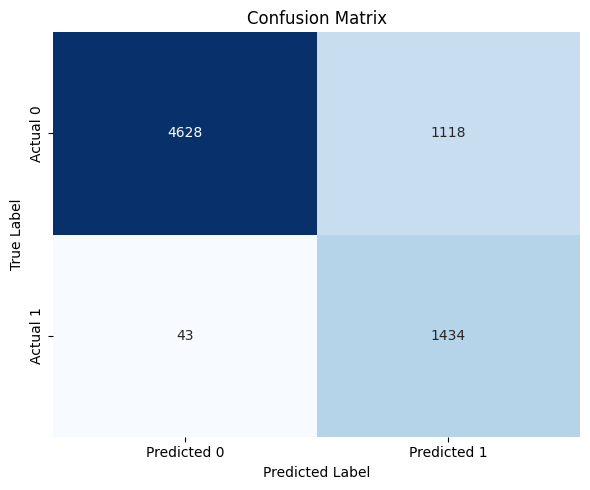

In [ ]:
# --- Inference and DataFrame creation ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

threshold = 0.5

results = []
all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch, meta_batch in test_loader:
        X_batch = X_batch.to(device)
        probs = model(X_batch)
        preds = (probs >= 0.5).int()

        for prob, pred, y_true, meta in zip(probs, preds, y_batch.numpy(), meta_batch):
            results.append({
                "Region": meta["Region"],
                "truckid": meta["truckid"],
                "Measurement_timestamp": meta["Measurement_timestamp"],
                "Maintenance_flag": int(y_true),
                "Prediction_Prob": float(prob),
                "Prediction_Label": int(pred)
            })
            all_true.append(int(y_true))
            all_pred.append(int(pred))
            all_probs.append(float(prob))

# --- Create result DataFrame ---
result_df = pd.DataFrame(results)
print(result_df.head())
result_df.to_csv("lstm_test_predictions.csv", index=False)

# --- Compute Metrics ---
conf_matrix = confusion_matrix(all_true, all_pred)
accuracy = accuracy_score(all_true, all_pred)
precision = precision_score(all_true, all_pred, zero_division=0)
recall = recall_score(all_true, all_pred, zero_division=0)
f1 = f1_score(all_true, all_pred, zero_division=0)
try:
    roc_auc = roc_auc_score(all_true, all_probs)
except:
    roc_auc = None

# --- Display Results ---
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
if roc_auc is not None:
    print(f"  ROC AUC:   {roc_auc:.4f}")
else:
    print("  ROC AUC:   Not computable (only one class in y_true)")

import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

# Save the figure
plt.savefig("lstm_confusion_matrix.png")
plt.show()


## Agentic AI

In [ ]:
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

# Prediction helper
def predict_maintenance(region: str, truckid: str, csv_path: str = "fleet_monitor_notscored_2.csv"):
    df = pd.read_csv(csv_path)
    df = df[df["Region"] == region]
    df = df[df["truckid"] == truckid]
    df["Measurement_timestamp"] = pd.to_datetime(df["Measurement_timestamp"], format="%d%b%y:%H:%M:%S")
    df = df.sort_values(by="Measurement_timestamp")
    
    if len(df) < SEQUENCE_LENGTH:
        return f"Not enough data for truck {truckid} in {region}."

    df[features] = scaler.transform(df[features])
    seq_data = df[features].tail(SEQUENCE_LENGTH).values
    X_seq = torch.tensor(seq_data, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        prob = model(X_seq).item()
    
    pred_label = "Needs Maintenance" if prob >= 0.5 else "OK"
    return f"Truck {truckid} in {region}: {pred_label} (prob={prob:.2f})"


In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# Define state
class MaintenanceState(TypedDict):
    region: str
    truckid: str
    result: str

# Nodes
def get_input(state: MaintenanceState):
    # In a real setup, replace with LLM parsing of user query
    return {"region": state["region"], "truckid": state["truckid"]}

def run_prediction(state: MaintenanceState):
    result = predict_maintenance(state["region"], state["truckid"])
    return {"result": result}

def show_output(state: MaintenanceState):
    print(state["result"])
    return state

# Build graph
graph = StateGraph(MaintenanceState)
graph.add_node("get_input", get_input)
graph.add_node("predict", run_prediction)
graph.add_node("output", show_output)

graph.set_entry_point("get_input")
graph.add_edge("get_input", "predict")
graph.add_edge("predict", "output")
graph.add_edge("output", END)

app = graph.compile()
